In [1]:
import os
import pandas as pd


root_pth = '/home/ddon0001/PhD/experiments/scaled/no_merges_all'
ds_summary_path = os.path.join(root_pth, 'summary.csv')
ds_info = pd.read_csv(ds_summary_path)[['ds_name', 'det_path']]

In [2]:
from utils import load_sol_files, populate_solution_label_including_ws

dfs = []
for row in ds_info.itertuples():
    # read all edges, solution graph, ground truth, sol_gt_mapping
    sol_pth = os.path.join(root_pth, row.ds_name)
    _, all_edges, solution_graph, _, _, _ = load_sol_files(sol_pth)

    # populate 'oracle_is_correct' column - both WS and FP edges are incorrect
    populate_solution_label_including_ws(all_edges, solution_graph)
    all_edges['solution_correct'] = (all_edges.flow > 0) == (all_edges.oracle_is_correct)
    # assign incorrect column as well for easy counting
    all_edges['solution_incorrect'] = all_edges.solution_correct == False
    all_edges['ds_name'] = row.ds_name
    # assign "prop diff" which is absolute difference in area proportion to 1
    all_edges['prop_diff'] = abs(all_edges['chosen_neighbour_area_prop'] - 1)
    # only keep solution edges
    dfs.append(all_edges[(all_edges.u >= 0) & (all_edges.v >= 0) & (all_edges.flow > 0)])

overall_df = pd.concat(dfs)

In [6]:
with_feature_ranks = []
for ds_name, df in overall_df.groupby('ds_name'):
    df['distance_rank'] = df['distance'].rank(ascending=False)
    df['sensitivity_rank'] = df['sensitivity_diff'].rank()
    df['area_rank'] = df['prop_diff'].rank(ascending=False)
    df['neighbour_rank'] = df['chosen_neighbour_rank'].rank(ascending=False)
    with_feature_ranks.append(df)
with_rank_df = pd.concat(with_feature_ranks) 

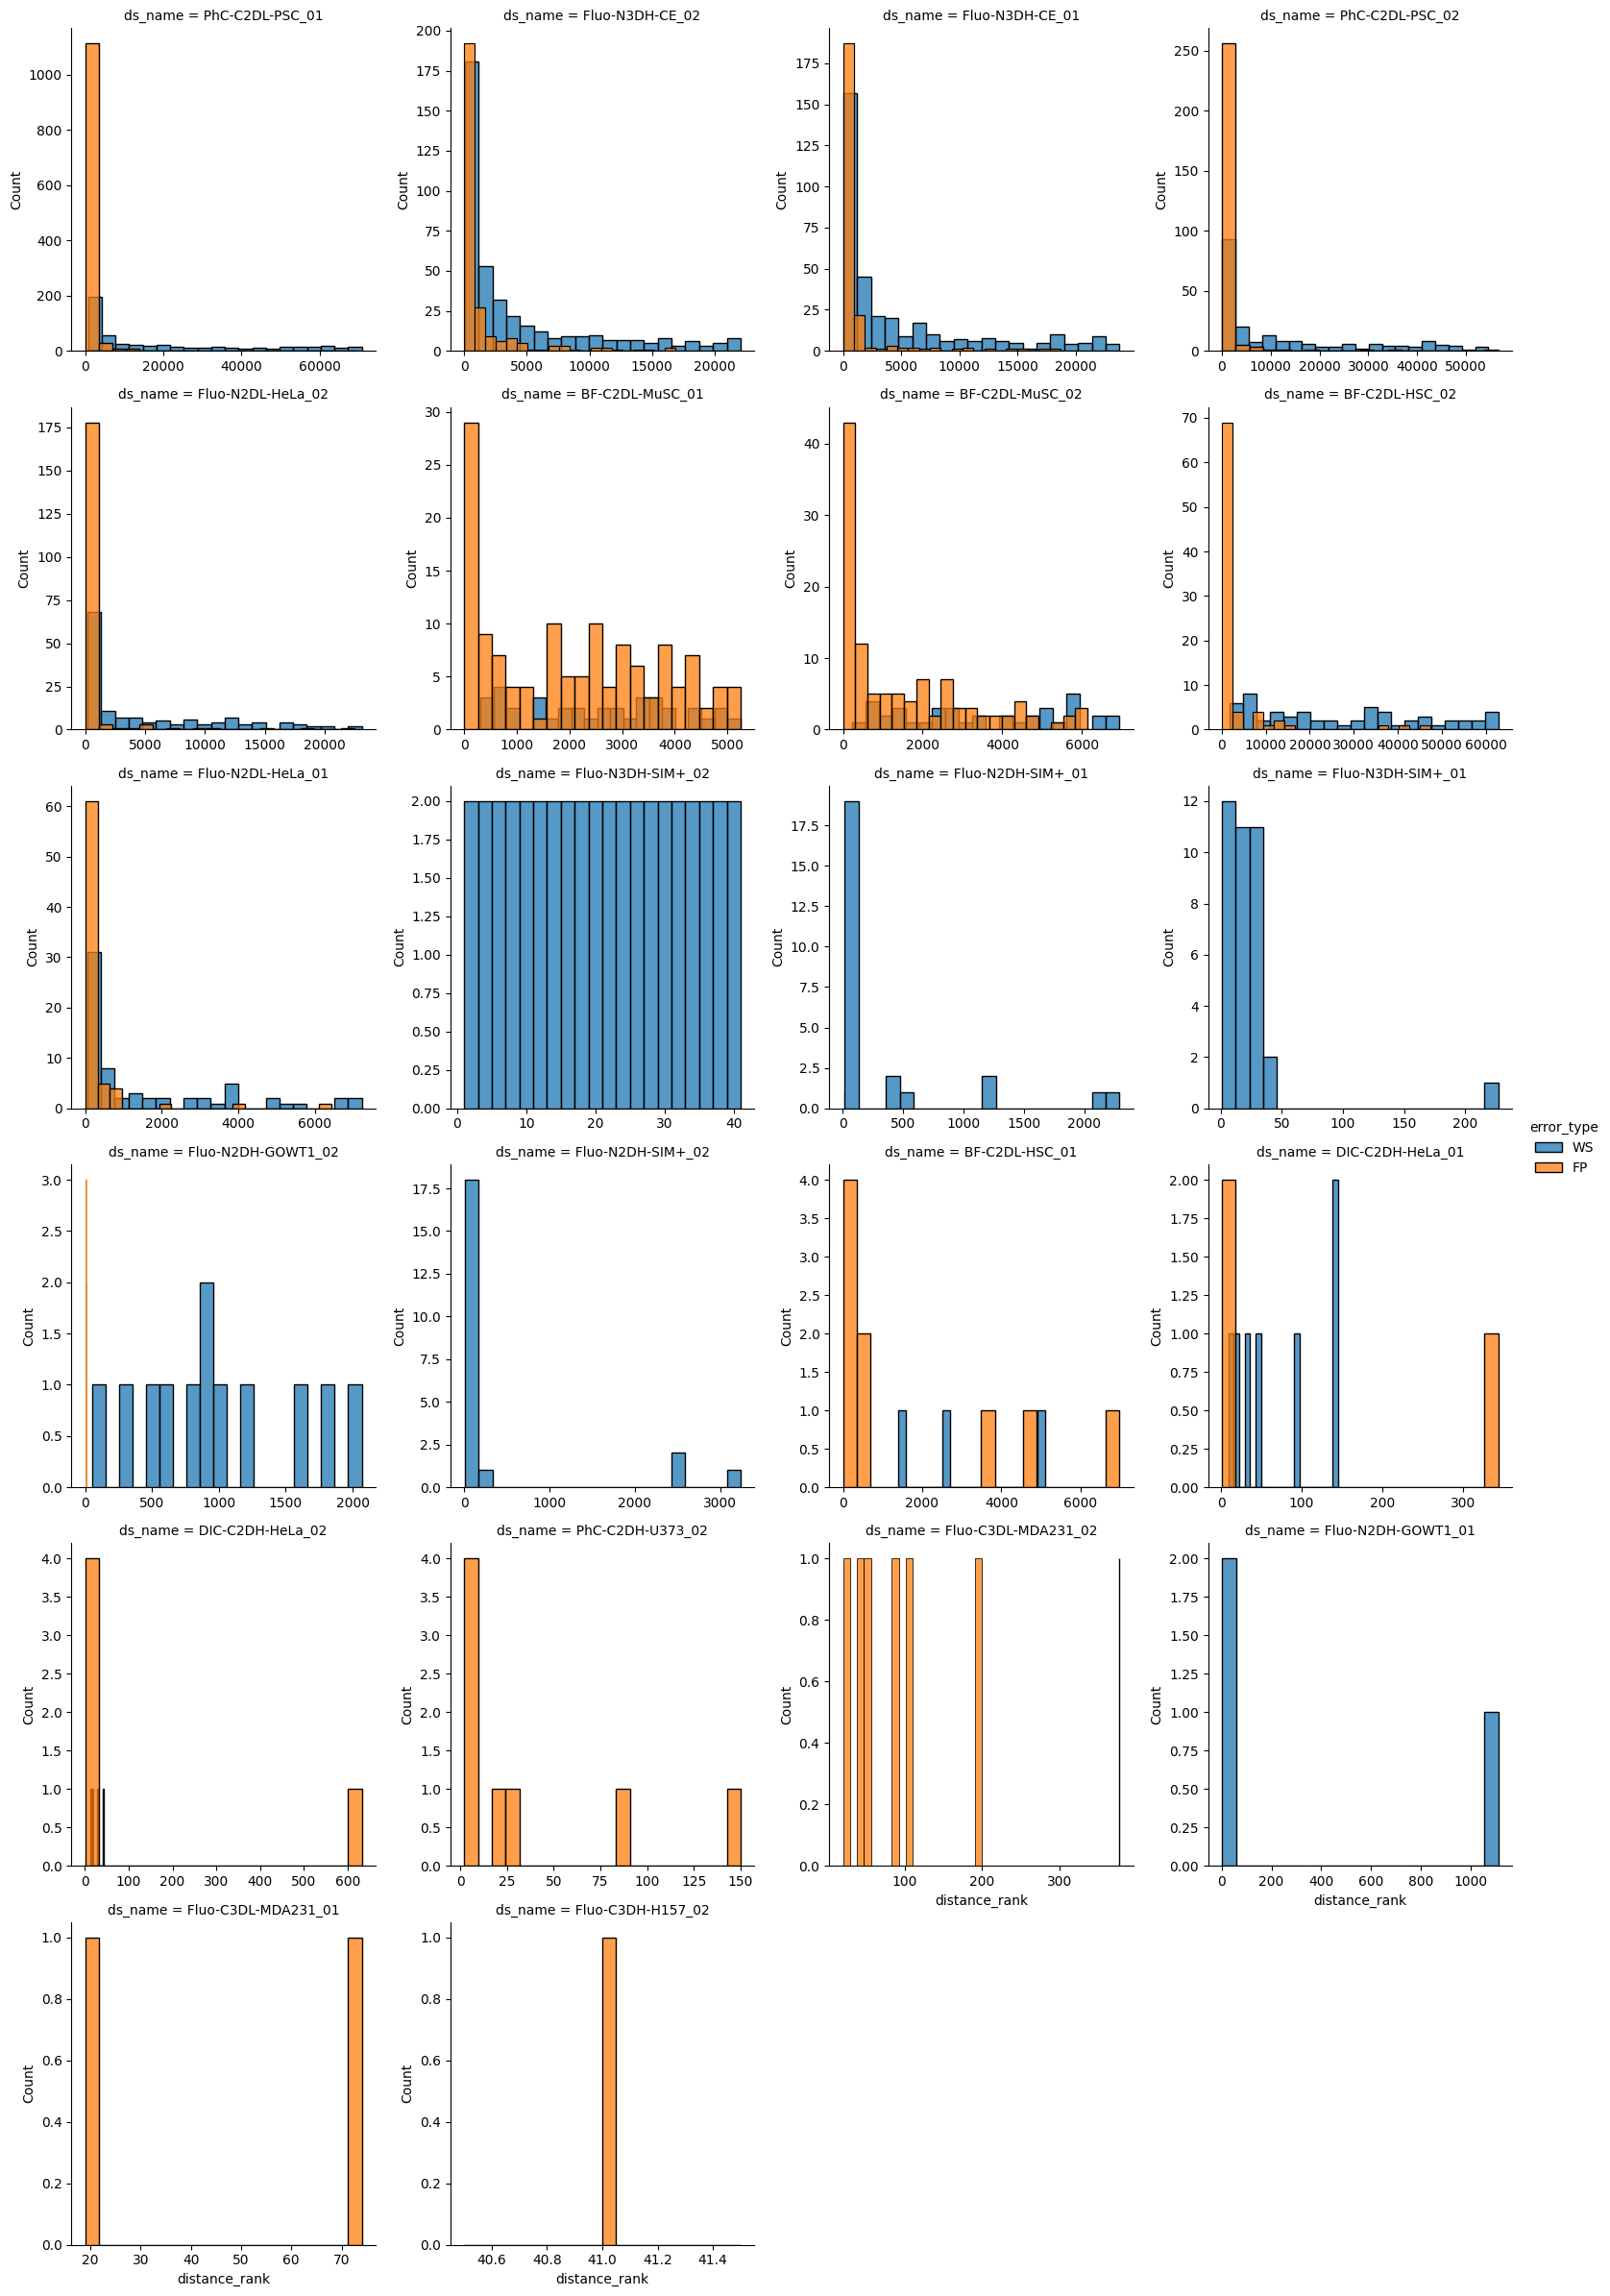

In [12]:
import seaborn as sns

only_errors = with_rank_df[with_rank_df.solution_incorrect]
plot_order = only_errors[only_errors.solution_incorrect].ds_name.value_counts().index

grid = sns.FacetGrid(only_errors, col='ds_name', col_wrap=4, height=4, hue='error_type', sharex=False, sharey=False, col_order=plot_order)
grid.map_dataframe(sns.histplot, x='distance_rank', bins=20)
grid.add_legend()

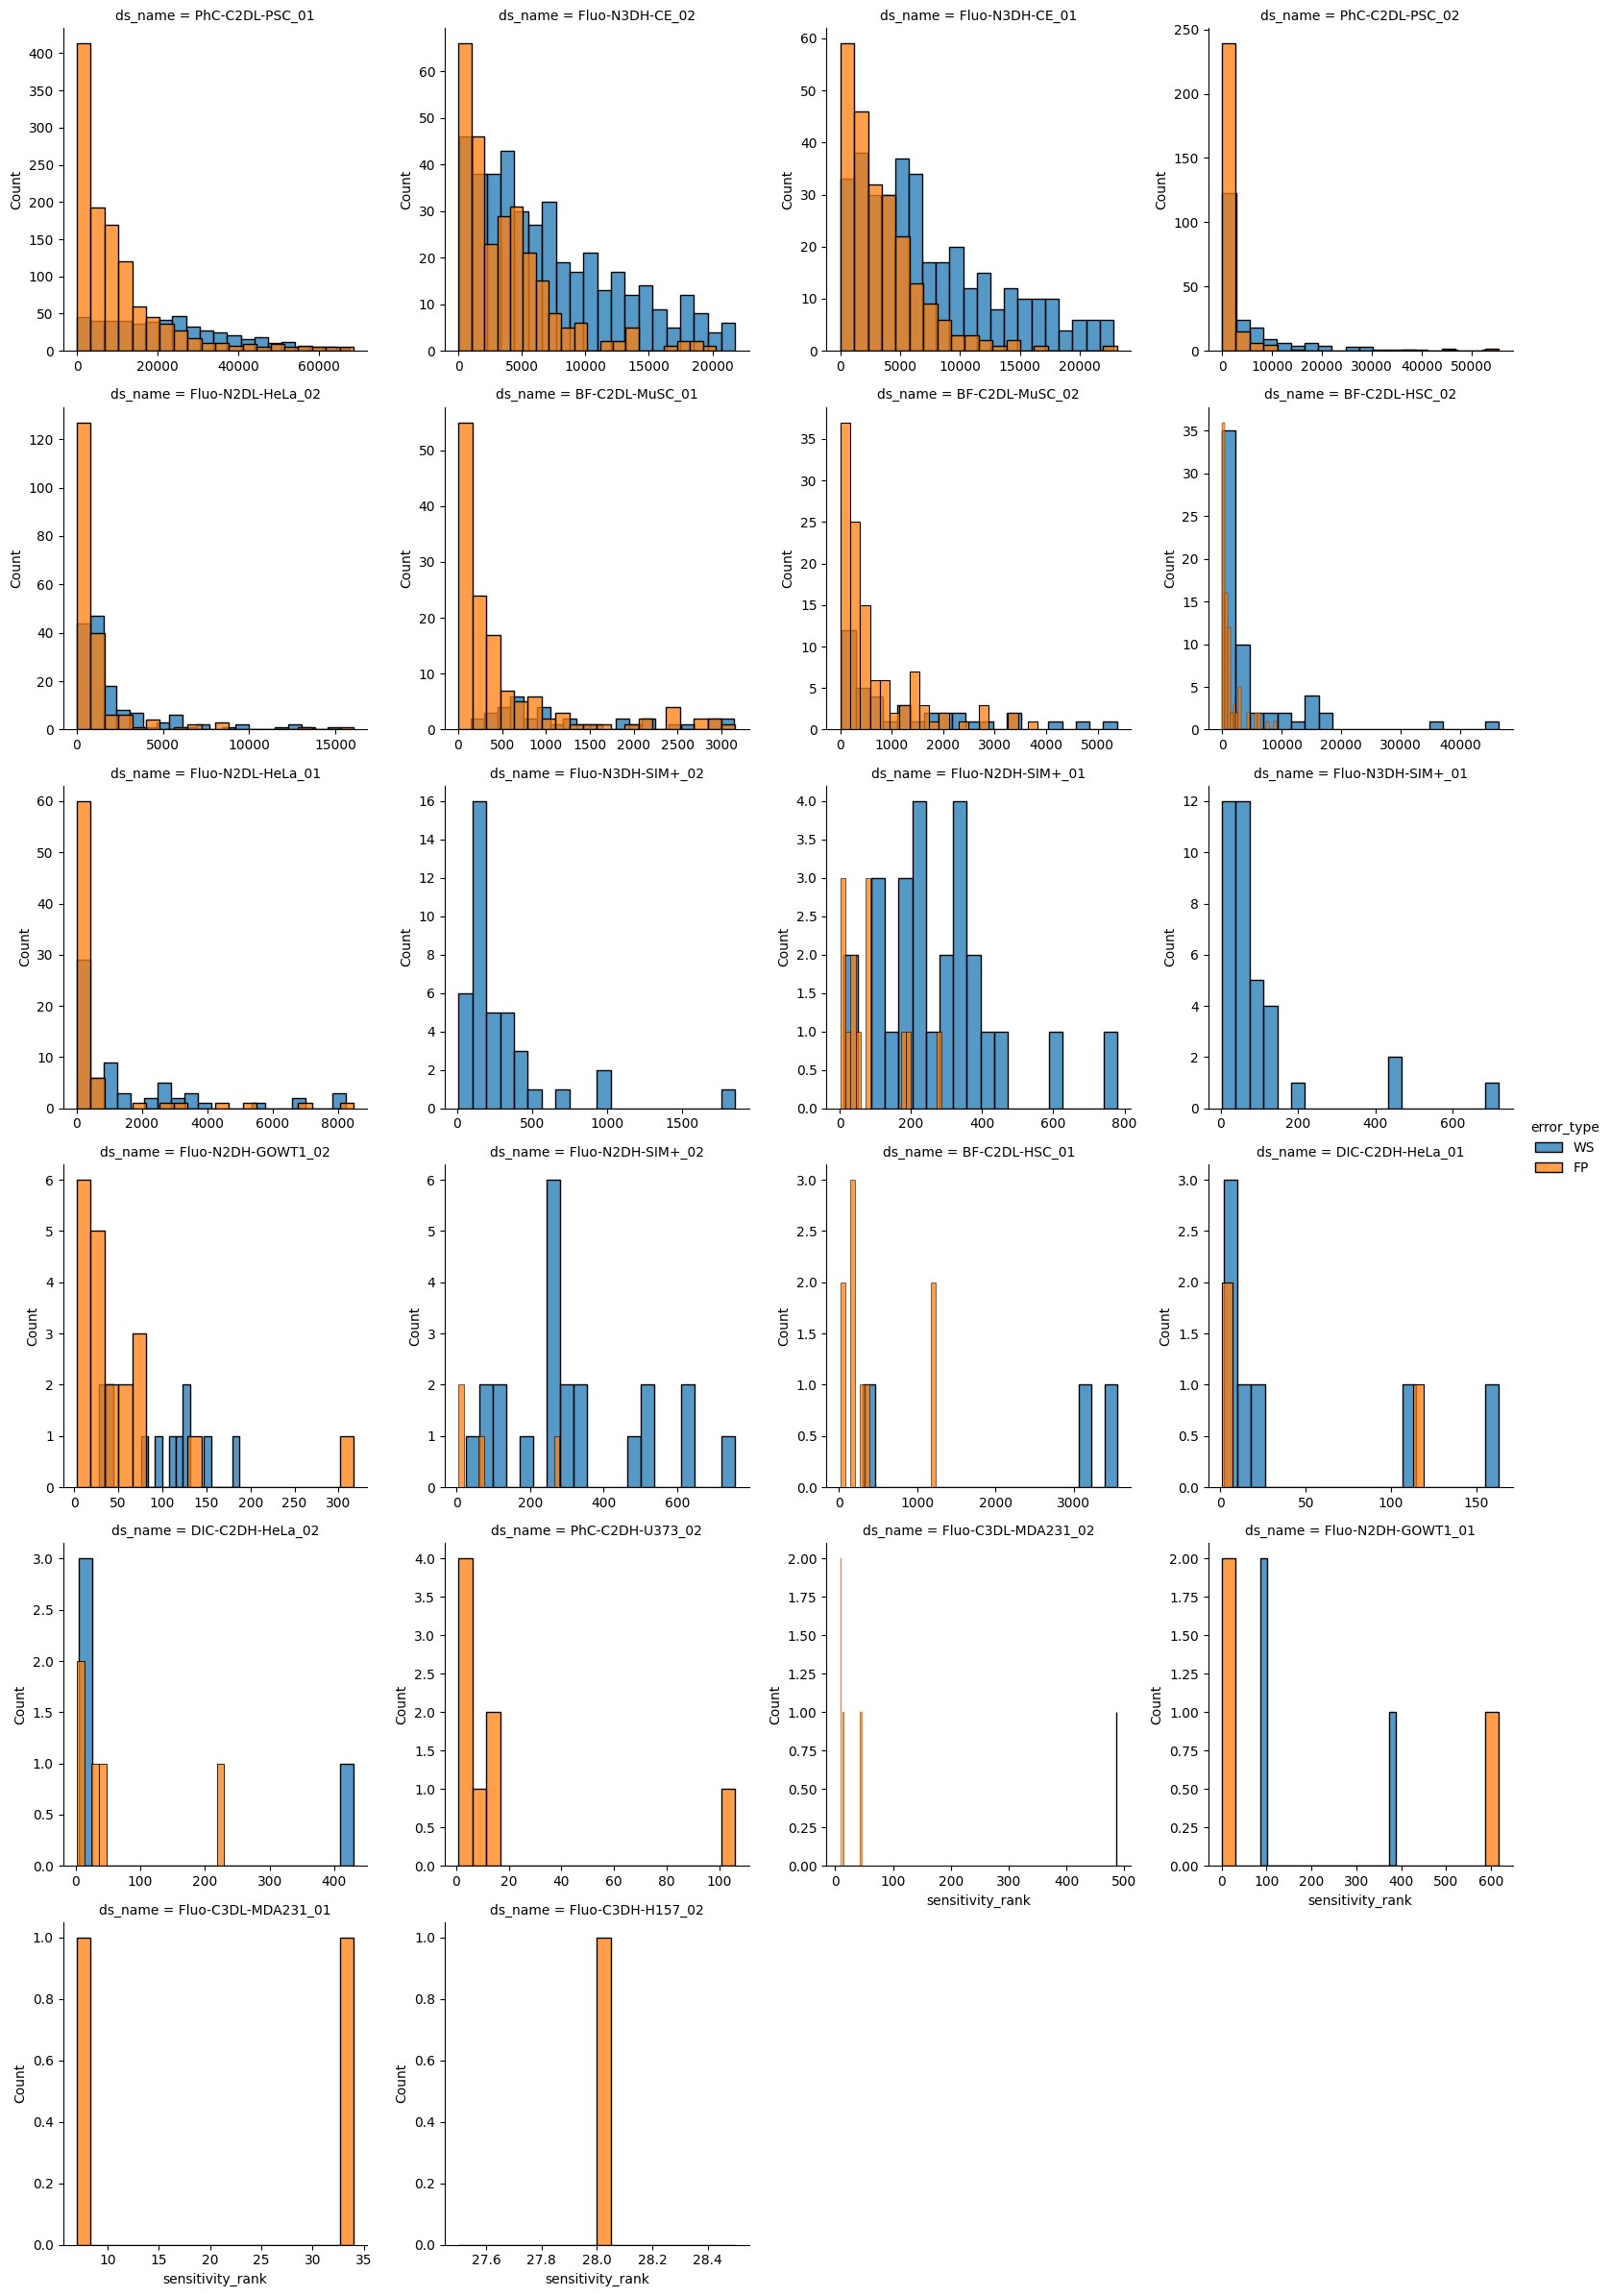

In [13]:
grid = sns.FacetGrid(only_errors, col='ds_name', col_wrap=4, height=4, hue='error_type', sharex=False, sharey=False, col_order=plot_order)
grid.map_dataframe(sns.histplot, x='sensitivity_rank', bins=20)
grid.add_legend()